<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/DemandsResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Читаем графы

In [ ]:
import pandas as pd
import numpy as np
import os # Выберите, откуда тяните папку
from google.colab import files

BITRATE_DENOMINATOR = 100

# По папке формируем словарь графов со структурой -
#                                                {'название графа (как в папке)':
#                                                       {'adj_matrix': матрица смежности взвешенного графа - веса capacity,
#                                                        'traffic_matrix': матрица корреспонденций,
#                                                        'nodes_params': {'degrees': список степеней вершин,
#                                                                         'source_demands': список суммарного входящего траффика,
#                                                                         'target_demands': список суммарного исходящего траффика,
#                                                                         'sum_demands': список усредненного траффика (source + target) / 2
#                                                                        }
#                                                       }
#                                                }

def csv_to_graph(path, demands_path, capacity_path):
  Df = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  df = Df.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()
  df['source'] = df['source'].astype(int)
  df['target'] = df['target'].astype(int)
  #df['length'] = df['length'].astype(float)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(int) // BITRATE_DENOMINATOR
  traffic_grouped = traffic.groupby(['source', 'target']).sum().reset_index()
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = df['source'].tolist()
  targets = df['target'].tolist()
  lengths = df['length'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_matrix = np.zeros((num_vertices, num_vertices))
  traffic_matrix = np.zeros((num_vertices, num_vertices))

  for source, target, length in zip(sources, targets, lengths):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    #adj_matrix[new_source, new_target] = length
    #adj_matrix[new_target, new_source] = length
    adj_matrix[new_source, new_target] = capacity_value
    adj_matrix[new_target, new_source] = capacity_value

  traffic_grouped['source'] = traffic_grouped['source'].map(vertex_mapping)
  traffic_grouped['target'] = traffic_grouped['target'].map(vertex_mapping)
  for _, row in traffic_grouped.iterrows():
    traffic_matrix[row['source'], row['target']] = row['bitrate']

  nodes_params = {}

  degrees = list(np.count_nonzero(adj_matrix, axis=1).astype(np.float64))
  nodes_params['degrees'] = degrees

  source_demands = list(np.sum(traffic_matrix, axis=1))
  nodes_params['source_demands'] = source_demands

  target_demands = list(np.sum(traffic_matrix, axis=0))
  nodes_params['target_demands'] = target_demands

  sum_demands = [(i + j)/2 for (i,j) in zip(source_demands, target_demands)]
  nodes_params['sum_demands'] = sum_demands

  return (adj_matrix, traffic_matrix, nodes_params)

def get_graphs(base_path, specified_graphs, flag=False):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs or flag:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      (adj_matrix, traffic_matrix, nodes_params) = csv_to_graph(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_matrix': adj_matrix, 'traffic_matrix': traffic_matrix, 'nodes_params': nodes_params}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола' # Свой путь
Graphs = get_graphs(path_to_folder, specified_graphs, True)

/tmp/ipython-input-654008851.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])
/tmp/ipython-input-654008851.py:34: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])
/tmp/ipython-input-654008851.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='Numb

In [8]:
def make_symmetric_traffic_matrix_sum(traffic_matrix):
    """
    Преобразует матрицу трафика в неориентированную версию путем суммирования трафика в обе стороны.
    """
    matrix = np.array(traffic_matrix)
    # Суммируем трафик в обе стороны: matrix[i,j] + matrix[j,i]
    symmetric_matrix = matrix + matrix.T

    # Обнуляем диагональ, так как трафик от узла к самому себе обычно не учитывается
    np.fill_diagonal(symmetric_matrix, 0)

    return symmetric_matrix.tolist()

# Формируем кортеж graphs_demands_matrices
graphs_demands_matrices = []

for graph_name, graph_data in Graphs.items():
    original_traffic = graph_data['traffic_matrix']
    symmetric_traffic = make_symmetric_traffic_matrix_sum(original_traffic)

    graphs_demands_matrices.append((graph_name, symmetric_traffic))

# Преобразуем в кортеж
graphs_demands_matrices = tuple(graphs_demands_matrices)

Смотрим распределение корреспонденций

Анализ распределения трафика по графам (с целевыми значениями capacity)
Графов для анализа: 14
Графы: ['cola_t10', 'v806e1152r2110d3183', 'cola_t3', 'v811e1166r2071d3183', 'cola_t7', 'cola_t8', 'cola_t5', 'cola_t2', 'cola_t6', '2024_southwest', 'cola_t1', '2024_south', 'cola_large', '2024_north']


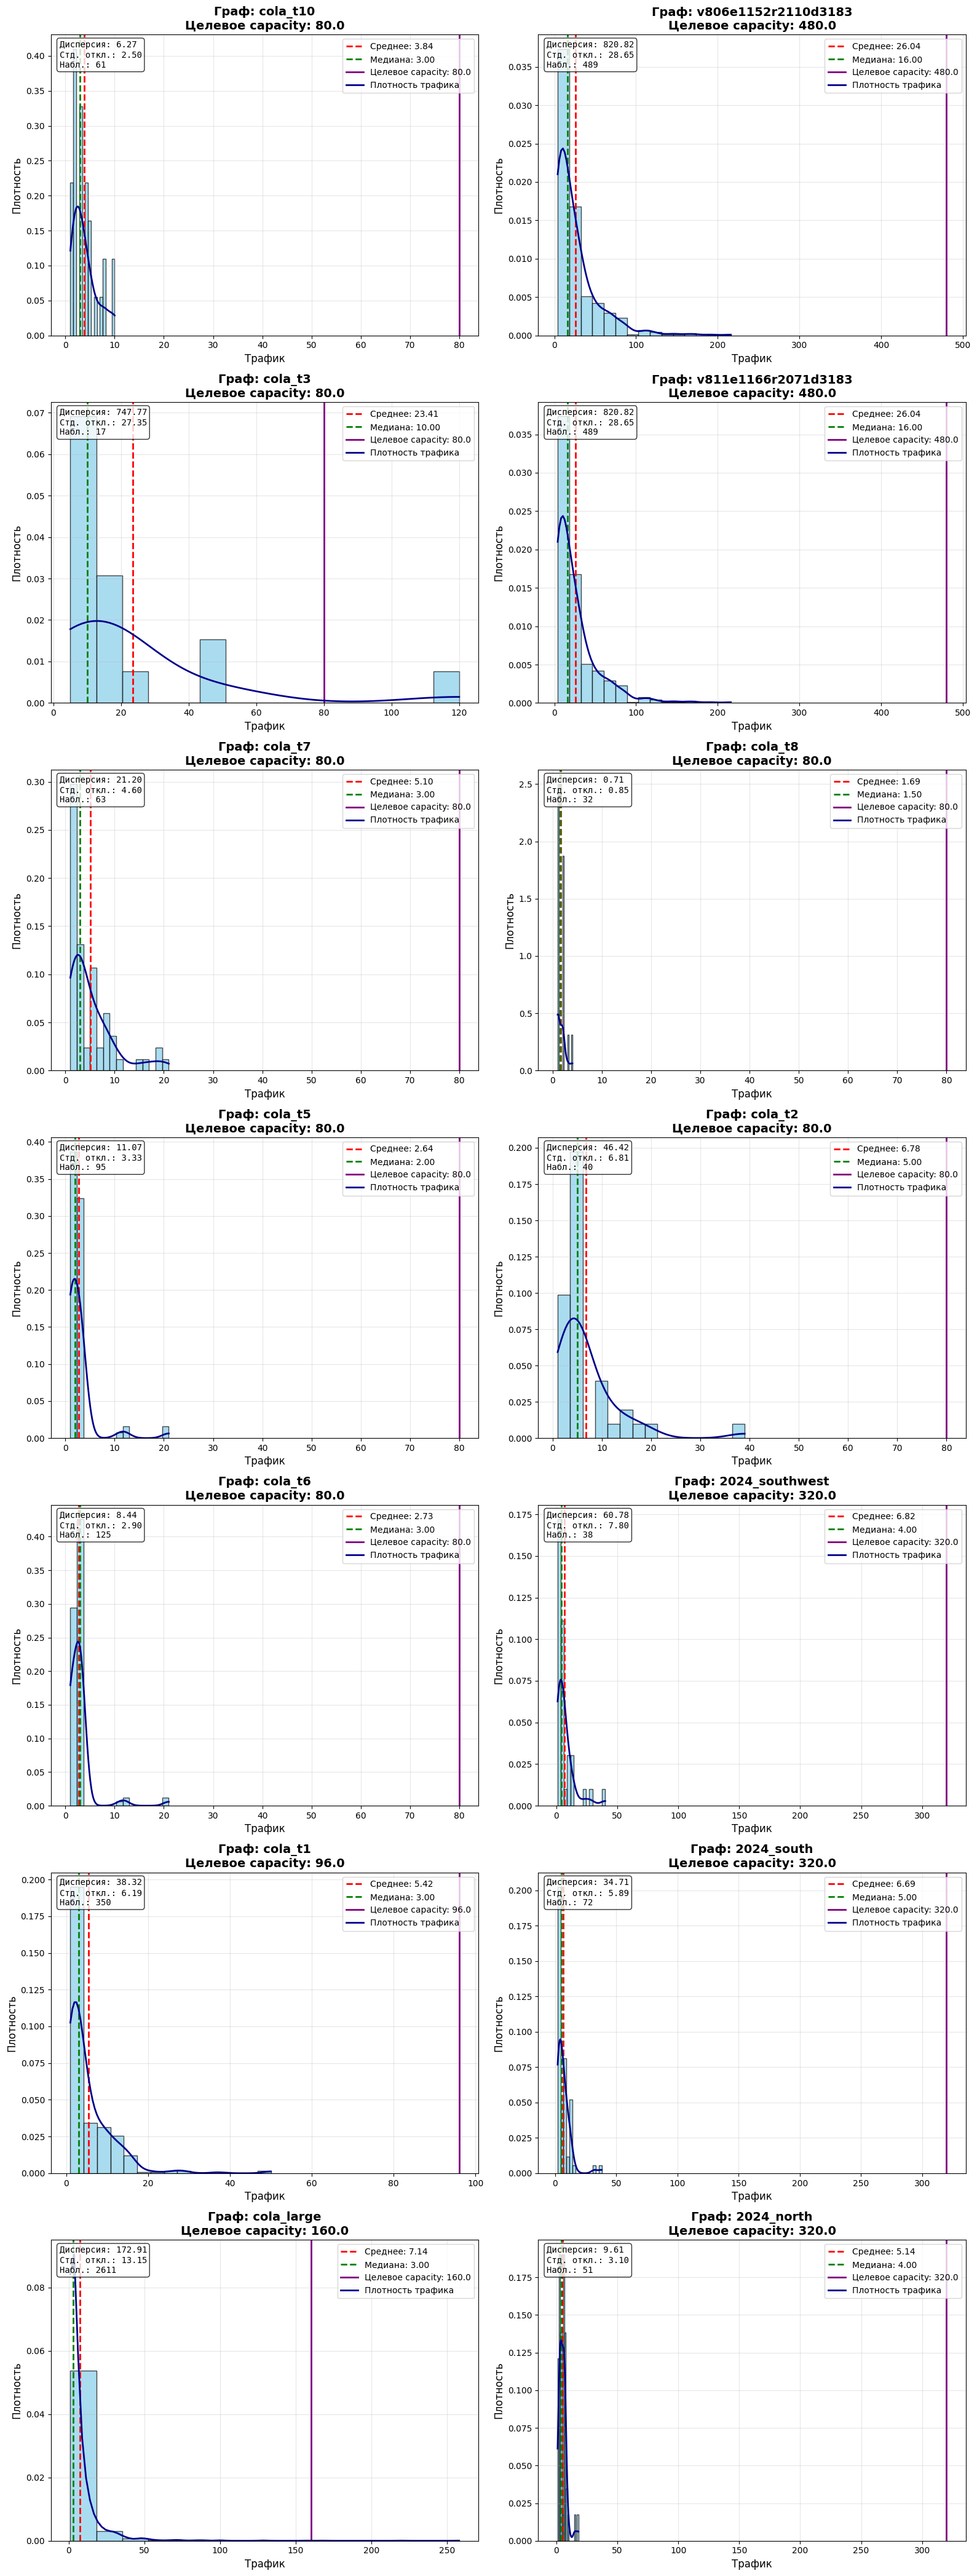


Статистики распределения трафика по графам (с целевыми значениями capacity):
Граф                 Среднее    Медиана    Целевое capacity     Отклонение      Набл.      Уник. трафик   
------------------------------------------------------------------------------------------------------------------------
cola_t10             3.84       3.00       80.0                 95.2%           61         9              
v806e1152r2110d3183  26.04      16.00      480.0                94.6%           489        33             
cola_t3              23.41      10.00      80.0                 70.7%           17         8              
v811e1166r2071d3183  26.04      16.00      480.0                94.6%           489        33             
cola_t7              5.10       3.00       80.0                 93.6%           63         15             
cola_t8              1.69       1.50       80.0                 97.9%           32         4              
cola_t5              2.64       2.00       80.0     

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import pandas as pd

# Настройка стиля
plt.style.use('default')
sns.set_palette("husl")

def filter_graphs(graphs_demands_matrices, Graphs):
    """Фильтруем графы, исключая cola_test60"""
    return [(name, matrix) for name, matrix in graphs_demands_matrices
            if name != 'cola_test60' and name in Graphs]

def get_target_capacity(graph_name, Graphs):
    """Получаем целевое значение capacity из матрицы смежности"""
    if graph_name not in Graphs:
        return None

    adj_matrix = np.array(Graphs[graph_name]['adj_matrix'])
    # Ищем уникальные ненулевые значения capacity
    capacity_values = adj_matrix[np.triu_indices_from(adj_matrix, k=1)]
    capacity_non_zero = capacity_values[capacity_values > 0]

    if len(capacity_non_zero) == 0:
        return None

    unique_capacities = np.unique(capacity_non_zero)
    return unique_capacities

def plot_histograms_per_graph_no_zeros(graphs_demands_matrices, Graphs):
    """Строит гистограммы распределения трафика для каждого графа с целевыми значениями"""

    # Фильтруем графы
    filtered_graphs = filter_graphs(graphs_demands_matrices, Graphs)

    if not filtered_graphs:
        print("Нет графов для анализа после фильтрации")
        return

    # Определяем количество графов и создаем subplots
    n_graphs = len(filtered_graphs)
    n_cols = 2  # Количество колонок
    n_rows = (n_graphs + n_cols - 1) // n_cols  # Округление вверх

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
    axes = axes.flatten() if n_graphs > 1 else [axes]

    for idx, (graph_name, symmetric_matrix) in enumerate(filtered_graphs):
        matrix = np.array(symmetric_matrix)

        # Извлекаем трафик между узлами (исключая диагональ) и убираем нули
        traffic_values = matrix[np.triu_indices_from(matrix, k=1)]
        traffic_non_zero = traffic_values[traffic_values > 0]

        # Получаем целевые значения capacity
        target_capacities = get_target_capacity(graph_name, Graphs)

        if len(traffic_non_zero) == 0:
            print(f"В графе {graph_name} нет ненулевого трафика")
            axes[idx].text(0.5, 0.5, f'Нет ненулевого трафика\nв графе {graph_name}',
                          ha='center', va='center', transform=axes[idx].transAxes, fontsize=12)
            axes[idx].set_title(f'Граф: {graph_name}', fontsize=14, fontweight='bold')
            continue

        # Вычисляем статистики (без нулей)
        mean_val = np.mean(traffic_non_zero)
        median_val = np.median(traffic_non_zero)
        variance_val = np.var(traffic_non_zero)
        std_val = np.std(traffic_non_zero)

        # Строим гистограмму
        ax = axes[idx]
        n, bins, patches = ax.hist(traffic_non_zero, bins=15, alpha=0.7, color='skyblue',
                                  edgecolor='black', density=True)

        # Добавляем линии для среднего и медианы
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_val:.2f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Медиана: {median_val:.2f}')

        # Добавляем целевые значения capacity
        if target_capacities is not None:
            for i, target_val in enumerate(target_capacities):
                color = 'purple' if i == 0 else 'orange'
                linestyle = '-' if len(target_capacities) == 1 else '--'
                label = f'Целевое capacity: {target_val:.1f}' if i == 0 else f'Capacity {i+1}: {target_val:.1f}'
                ax.axvline(target_val, color=color, linestyle=linestyle, linewidth=2, label=label)

        # Добавляем плотность распределения
        if len(traffic_non_zero) > 1:
            try:
                kde = gaussian_kde(traffic_non_zero)
                x_range = np.linspace(min(traffic_non_zero), max(traffic_non_zero), 100)
                ax.plot(x_range, kde(x_range), color='darkblue', linewidth=2, label='Плотность трафика')
            except:
                pass

        # Настройка графика
        title = f'Граф: {graph_name}'
        if target_capacities is not None:
            title += f'\nЦелевое capacity: {", ".join([f"{val:.1f}" for val in target_capacities])}'
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Трафик', fontsize=12)
        ax.set_ylabel('Плотность', fontsize=12)
        ax.grid(True, alpha=0.3)

        # Создаем легенду со статистиками
        stats_text = f'Дисперсия: {variance_val:.2f}\nСтд. откл.: {std_val:.2f}\nНабл.: {len(traffic_non_zero)}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=10, fontfamily='monospace')

        ax.legend(loc='upper right')

    # Скрываем пустые subplots
    for idx in range(n_graphs, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

def print_statistics_table_no_zeros(graphs_demands_matrices, Graphs):
    """Выводит таблицу со статистиками для каждого графа с целевыми значениями"""

    # Фильтруем графы
    filtered_graphs = filter_graphs(graphs_demands_matrices, Graphs)

    if not filtered_graphs:
        print("Нет графов для анализа после фильтрации")
        return

    print("\nСтатистики распределения трафика по графам (с целевыми значениями capacity):")
    print("=" * 120)
    print(f"{'Граф':<20} {'Среднее':<10} {'Медиана':<10} {'Целевое capacity':<20} {'Отклонение':<15} {'Набл.':<10} {'Уник. трафик':<15}")
    print("-" * 120)

    for graph_name, symmetric_matrix in filtered_graphs:
        matrix = np.array(symmetric_matrix)
        traffic_values = matrix[np.triu_indices_from(matrix, k=1)]
        traffic_non_zero = traffic_values[traffic_values > 0]

        # Получаем целевые значения capacity
        target_capacities = get_target_capacity(graph_name, Graphs)
        target_str = ", ".join([f"{val:.1f}" for val in target_capacities]) if target_capacities is not None else "нет данных"

        if len(traffic_non_zero) == 0:
            print(f"{graph_name:<20} {'-':<10} {'-':<10} {target_str:<20} {'-':<15} {0:<10} {'-':<15}")
            continue

        mean_val = np.mean(traffic_non_zero)
        median_val = np.median(traffic_non_zero)
        unique_traffic = len(np.unique(traffic_non_zero))

        # Вычисляем отклонение от целевого значения (берем первое целевое значение)
        deviation = ""
        if target_capacities is not None and len(target_capacities) > 0:
            target_val = target_capacities[0]  # Берем первое целевое значение
            deviation_pct = abs((mean_val - target_val) / target_val) * 100
            deviation = f"{deviation_pct:.1f}%"

        print(f"{graph_name:<20} {mean_val:<10.2f} {median_val:<10.2f} {target_str:<20} {deviation:<15} {len(traffic_non_zero):<10} {unique_traffic:<15}")

def print_unique_weights_table(graphs_demands_matrices, Graphs):
    """Выводит таблицу с уникальными ненулевыми значениями весов для каждого графа"""

    # Фильтруем графы
    filtered_graphs = filter_graphs(graphs_demands_matrices, Graphs)

    if not filtered_graphs:
        print("Нет графов для анализа после фильтрации")
        return

    print("\nУникальные ненулевые значения весов трафика по графам (с целевыми capacity):")
    print("=" * 100)
    print(f"{'Граф':<20} {'Целевое capacity':<20} {'Уник. трафик':<40} {'Ср. трафик':<12} {'Отклонение':<12}")
    print("-" * 100)

    for graph_name, symmetric_matrix in filtered_graphs:
        matrix = np.array(symmetric_matrix)
        traffic_values = matrix[np.triu_indices_from(matrix, k=1)]
        traffic_non_zero = traffic_values[traffic_values > 0]

        # Получаем целевые значения capacity
        target_capacities = get_target_capacity(graph_name, Graphs)
        target_str = ", ".join([f"{val:.1f}" for val in target_capacities]) if target_capacities is not None else "нет данных"

        if len(traffic_non_zero) == 0:
            print(f"{graph_name:<20} {target_str:<20} {'нет ненулевых':<40} {'-':<12} {'-':<12}")
            continue

        # Уникальные значения трафика
        unique_vals = np.unique(traffic_non_zero)
        mean_traffic = np.mean(traffic_non_zero)

        # Форматируем уникальные значения для вывода
        if len(unique_vals) <= 4:
            unique_str = ", ".join([f"{val:.1f}" for val in unique_vals])
        else:
            unique_str = f"{unique_vals[0]:.1f}-{unique_vals[-1]:.1f} ({len(unique_vals)} значений)"

        # Отклонение от целевого capacity
        deviation_str = ""
        if target_capacities is not None and len(target_capacities) > 0:
            target_val = target_capacities[0]
            deviation_pct = ((mean_traffic - target_val) / target_val) * 100
            deviation_str = f"{deviation_pct:+.1f}%"

        print(f"{graph_name:<20} {target_str:<20} {unique_str:<40} {mean_traffic:<12.2f} {deviation_str:<12}")

def analyze_capacity_vs_traffic(graphs_demands_matrices, Graphs):
    """Анализ соотношения целевого capacity и фактического трафика"""

    # Фильтруем графы
    filtered_graphs = filter_graphs(graphs_demands_matrices, Graphs)

    if not filtered_graphs:
        return

    print("\nАнализ соотношения целевого capacity и фактического трафика:")
    print("=" * 80)

    comparisons = []

    for graph_name, symmetric_matrix in filtered_graphs:
        matrix = np.array(symmetric_matrix)
        traffic_values = matrix[np.triu_indices_from(matrix, k=1)]
        traffic_non_zero = traffic_values[traffic_values > 0]

        if len(traffic_non_zero) == 0:
            continue

        target_capacities = get_target_capacity(graph_name, Graphs)
        if target_capacities is None or len(target_capacities) == 0:
            continue

        target_val = target_capacities[0]  # Берем первое целевое значение
        mean_traffic = np.mean(traffic_non_zero)
        median_traffic = np.median(traffic_non_zero)
        max_traffic = np.max(traffic_non_zero)

        # Вычисляем различные метрики
        mean_deviation_pct = ((mean_traffic - target_val) / target_val) * 100
        median_deviation_pct = ((median_traffic - target_val) / target_val) * 100
        max_utilization_pct = (max_traffic / target_val) * 100

        comparisons.append({
            'graph_name': graph_name,
            'target_capacity': target_val,
            'mean_traffic': mean_traffic,
            'median_traffic': median_traffic,
            'max_traffic': max_traffic,
            'mean_deviation_pct': mean_deviation_pct,
            'max_utilization_pct': max_utilization_pct
        })

        print(f"\n{graph_name}:")
        print(f"  Целевое capacity: {target_val:.1f}")
        print(f"  Средний трафик: {mean_traffic:.1f} ({mean_deviation_pct:+.1f}%)")
        print(f"  Медианный трафик: {median_traffic:.1f} ({median_deviation_pct:+.1f}%)")
        print(f"  Максимальный трафик: {max_traffic:.1f} ({max_utilization_pct:.1f}% от capacity)")

    # Сводная статистика
    if comparisons:
        avg_deviation = np.mean([c['mean_deviation_pct'] for c in comparisons])
        max_utilization = np.max([c['max_utilization_pct'] for c in comparisons])

        print(f"\nСводка по всем графам:")
        print(f"  Среднее отклонение трафика от capacity: {avg_deviation:+.1f}%")
        print(f"  Максимальная утилизация capacity: {max_utilization:.1f}%")

# Основной код выполнения
print("Анализ распределения трафика по графам (с целевыми значениями capacity)")
print("=" * 80)

# Проверяем, какие графы остались после фильтрации
filtered_graphs = filter_graphs(graphs_demands_matrices, Graphs)
print(f"Графов для анализа: {len(filtered_graphs)}")
print("Графы:", [name for name, _ in filtered_graphs])

# Строим гистограммы с целевыми значениями
plot_histograms_per_graph_no_zeros(graphs_demands_matrices, Graphs)

# Выводим таблицу статистик с целевыми значениями
print_statistics_table_no_zeros(graphs_demands_matrices, Graphs)

# Выводим таблицу с уникальными значениями
print_unique_weights_table(graphs_demands_matrices, Graphs)

# Детальный анализ соотношения capacity и трафика
analyze_capacity_vs_traffic(graphs_demands_matrices, Graphs)

print("\nАнализ завершен. Граф 'cola_test60' исключен из анализа.")